In [88]:
import tensorflow as tf
from numpy import zeros

In [89]:
filenames = "gs://mom_seguros_images_car/ic/train/train/*/*.png"
main_filepath = "gs://mom_seguros_images_car/ic/train/train/*"

In [90]:
filepath = tf.io.gfile.glob(filenames)

In [91]:
filepath

['gs://mom_seguros_images_car/ic/train/train/correct/0.9526_car_b7cdd35a-68a9-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9541_car_d1d8232c-68d6-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9548_car_a5fcb34e-68db-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9549_car_4cab15a4-68e2-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9549_car_7475b666-68d3-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9560_car_04a6da4e-68de-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9561_car_2c814fae-68b6-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9561_car_343d7ab6-68d8-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/train/train/correct/0.9565_car_a9cf3d18-68c5-11ed-b6d3-ce59abab15a2.png',
 'gs://mom_seguros_images_car/ic/trai

In [92]:
# Get labels from folder's name and create a map to an ID
def get_label_map(path: str):
    """
    Get the subfolders from a path, each folder correspond to a label.
    path: str -> example: "gs://mom_seguros_images_car/ic/train/*"
    """
    #list folders in this path
    folders_name = tf.io.gfile.glob(path)

    labels = []
    for folder in folders_name:
        labels.append(folder.split(sep='/')[-1])

    # Generate a Label Map and Interted Label Map
    label_map = {labels[i]:i for i in range(len(labels))}
    inv_label_map = {i:labels[i] for i in range(len(labels))}
    
    return label_map, inv_label_map

In [93]:
get_label_map(main_filepath)

({'correct': 0, 'incorrect': 1}, {0: 'correct', 1: 'incorrect'})

In [94]:
# One hot encode the image's labels
def one_hot_encode(label_map: dict, filepath: list) -> dict:
    labels = dict()
    
    for i in range(len(filepath)):
        encoding = zeros(len(label_map), dtype='uint8')
        encoding[label_map[filepath[i].split(sep='/')[-2]]] = 1
        
        labels.update({filepath[i]:list(encoding)})
    
    return labels

def assign_label(label_map: dict, filepath: list) -> dict:
    labels = dict()

    for i in range(len(filepath)):
        label = filepath[i].split('/')[-2]
        if label not in list(label_map.keys()):
            raise NotImplementedError(f'Label {label} not included in label map')
        
        labels.update({filepath[i]:label_map[label]})

    return labels

In [95]:
label_map, inv_label_map = get_label_map(main_filepath)

In [96]:
list(label_map.items())[:5]

[('correct', 0), ('incorrect', 1)]

In [97]:
# List all files in bucket
filepath = tf.io.gfile.glob(filenames)
NUM_TOTAL_IMAGES = len(filepath)

In [98]:
label_map = {'correct': 1, 'incorrect': 0}
dataset = assign_label(label_map, filepath)
dataset = [[k,v] for k,v in dataset.items()]

In [99]:
features = [i[0] for i in dataset]
labels = [i[1] for i in dataset]

In [100]:
labels[1]

1

In [101]:
# Create Dataset from Features and Labels
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

In [102]:
print(next(iter(dataset)))

(<tf.Tensor: shape=(), dtype=string, numpy=b'gs://mom_seguros_images_car/ic/train/train/correct/0.9526_car_b7cdd35a-68a9-11ed-b6d3-ce59abab15a2.png'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


2022-12-15 16:16:17.724582: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [103]:
for i in dataset.take(1):
  print(i[0])

tf.Tensor(b'gs://mom_seguros_images_car/ic/train/train/correct/0.9526_car_b7cdd35a-68a9-11ed-b6d3-ce59abab15a2.png', shape=(), dtype=string)


In [104]:
i[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'gs://mom_seguros_images_car/ic/train/train/correct/0.9526_car_b7cdd35a-68a9-11ed-b6d3-ce59abab15a2.png'>

In [105]:
raw_bytes = tf.io.read_file(i[0])

In [106]:
raw_png = tf.io.decode_png(raw_bytes, channels=3)

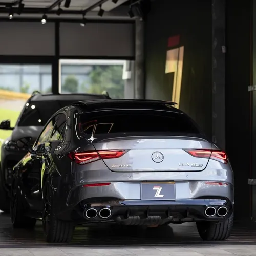

In [107]:
tf.keras.utils.array_to_img(raw_png)

In [108]:
def get_bytes_label(filepath, label):
    raw_bytes = tf.io.read_file(filepath)
    return raw_bytes, label

In [109]:
def process_image(raw_bytes, label):
    image = tf.io.decode_png(raw_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (256, 256)) # needed in order to have correct shape otherwise it gets None shape in training
    
    return image, label

In [110]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_dataset(dataset, batch_size=BATCH_SIZE, cache=False):
    
    dataset = dataset.shuffle(NUM_TOTAL_IMAGES)
    
    # Extraction: IO Intensive
    dataset = dataset.map(get_bytes_label, num_parallel_calls=AUTOTUNE)

    # Transformation: CPU Intensive
    dataset = dataset.map(process_image, num_parallel_calls=AUTOTUNE)
    # dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size)
    
    if cache:
        if isinstance(cache, str):
            dataset = dataset.cache(filename=cache)
        else:
            dataset = dataset.cache()
    
    # Pipeline next iteration
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [111]:
# Apply transformations to the dataset with images paths and labels
train_ds = build_dataset(dataset)

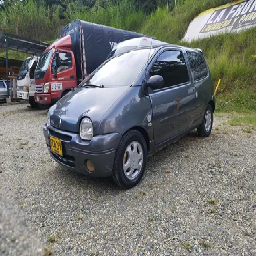

In [112]:
tf.keras.utils.array_to_img(next(iter(train_ds))[0][0])

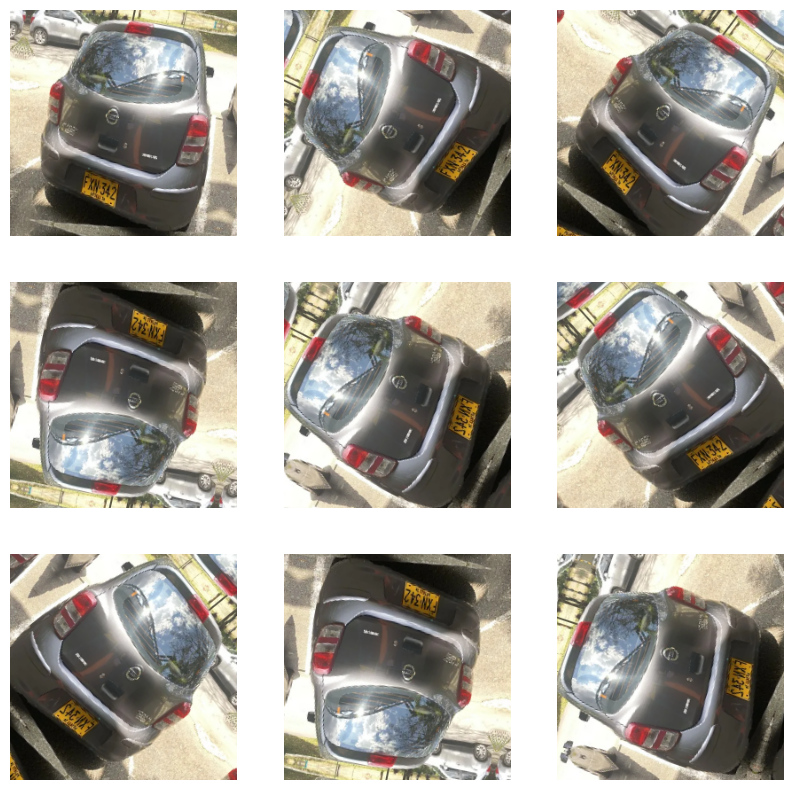

In [113]:
import matplotlib.pyplot as plt

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

image = next(iter(train_ds))[0][0]

tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tf.keras.utils.array_to_img(augmented_image))
  plt.axis("off")

In [114]:
print(f'List GPUs: {tf.config.list_physical_devices("GPU")}')

List GPUs: []


In [115]:
REGULARIZATION_LAMBDA = 0.000025

model = tf.keras.models.Sequential([
    data_augmentation,
    # tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [116]:
next(iter(train_ds))

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.7607844 , 0.94117653, 0.97647065],
          [0.7607844 , 0.93725497, 0.9843138 ],
          [0.7607844 , 0.93725497, 0.9843138 ],
          ...,
          [0.57254905, 0.38823533, 0.3137255 ],
          [0.56078434, 0.3803922 , 0.29803923],
          [0.6039216 , 0.41176474, 0.33333334]],
 
         [[0.7725491 , 0.9333334 , 0.9843138 ],
          [0.7725491 , 0.9333334 , 0.97647065],
          [0.7725491 , 0.9333334 , 0.97647065],
          ...,
          [0.67058825, 0.48627454, 0.4156863 ],
          [0.6627451 , 0.4784314 , 0.40784317],
          [0.6       , 0.40784317, 0.3372549 ]],
 
         [[0.77647066, 0.91372555, 0.9843138 ],
          [0.7843138 , 0.9294118 , 0.97647065],
          [0.79215693, 0.9294118 , 0.9607844 ],
          ...,
          [0.654902  , 0.4784314 , 0.42352945],
          [0.7294118 , 0.5529412 , 0.49411768],
          [0.5686275 , 0.3803922 , 0.3254902 ]],
 
         ...,
 
      

In [117]:
model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.01),
  metrics=['accuracy'],
)

history = model.fit(
  train_ds,
  epochs=5,
  verbose=1,
)

Epoch 1/5
 41/401 [==>...........................] - ETA: 20:24 - loss: 1.1969 - accuracy: 0.4992

KeyboardInterrupt: 